In [1]:
import glob
import os
import cv2
import glob
import importlib

import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.traces as traceutils
import pylab as pl


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
import h5py
import json
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg

import analyze2p.scatter as sct

In [4]:
visual_areas=['V1', 'Lm', 'Li']
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


## Load NP receptive field fits

In [6]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
traceid='traces001'
fit_thr=0.5
# ------------------------------------------------------------
response_type='dff'
is_neuropil=True
do_spherical_correction=False

In [8]:
va = 'V1'
dk  = '20190504_JC078_fov1'
experiment='rfs'

# meta['session_int'] = meta['session'].astype(int)

meta[(meta.datakey==dk) & (meta.visual_area==va)]
#             & (meta['session_int']>=20190511)].copy()
# # dsets

,experiment,visual_area,datakey,fov,animalid,session,fovnum
162,rfs,V1,20190504_JC078_fov1,FOV1_zoom2p0x,JC078,20190504,1


## Calculate gradient from TILES map

In [67]:

target_sigma_um=20
desired_radius_um=20
smooth_spline_x=1
smooth_spline_y=1
create_new=False
redo_smooth=True
is_neuropil=True
ds_factor=1

In [68]:
print(va, dk, experiment)
# Load maps for NP background estimation) -- these are results from
# Nb identify_visual_areas.ipynb (manual)
# va='Lm'
# retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
#                                                             create_new=False)

Lm 20190504_JC078_fov1 rfs


Lm 20190504_JC078_fov1 rfs


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py:461: RuntimeWarning: invalid value encountered in true_divide
  azim_np = np.true_divide(np.nansum(azim_, axis=0), ixs)
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py:464: RuntimeWarning: invalid value encountered in true_divide
  elev_np = np.true_divide(np.nansum(elev_, axis=0), ixs)
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1142: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW


Target: 20 (fwhm=10, k=(1, 1))
start 0.0 78.3432614804411
smoothed 0.0 75.3893890787226


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:267: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:268: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


fillnan 0.0 75.3893890787226
fillnan 0.0 75.3893890787226


<IPython.core.display.Javascript object>


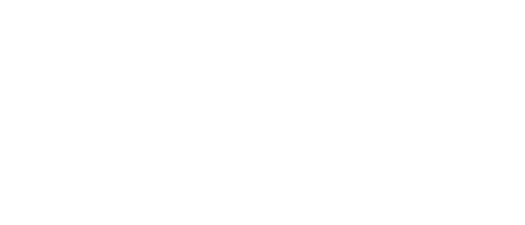

In [70]:
print(va, dk, experiment)
# Check NP maps from TILE protocol:
res = sct.get_background_maps(dk, experiment=experiment, traceid=traceid,
                        response_type=response_type, is_neuropil=True,  
                        do_spherical_correction=do_spherical_correction,    
                        create_new=False, redo_smooth=False, 
                        target_sigma_um=target_sigma_um, 
                        smooth_spline_x=smooth_spline_x, 
                        smooth_spline_y=smooth_spline_y, ds_factor=ds_factor)
az_map_TILE = res['azim_final'].copy()
el_map_TILE = res['elev_final'].copy()
#Check input maps (for MOVINGBAR-based background estimation):
azmap_input, elmap_input = sct.load_neuropil_background(dk, retinorun, 
                                                   map_type='start', protocol='TILE')

<IPython.core.display.Javascript object>


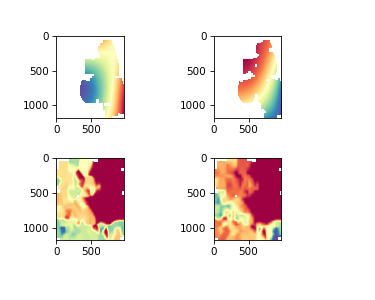

In [73]:
%matplotlib notebook
cmap='Spectral'
fig, axn= pl.subplots(2,2,figsize=(5,4))
ax=axn[0,0]
ax.imshow(AZMAP_NP, cmap=cmap)
ax=axn[0, 1]
ax.imshow(ELMAP_NP, cmap=cmap)

ax=axn[1,0]
ax.imshow(az_map_TILE, cmap=cmap)
ax=axn[1, 1]
ax.imshow(el_map_TILE, cmap=cmap)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, wspace=0.5, hspace=0.5)

#### Calculate gradients from NP background iamge

In [72]:
fit_results, fit_params = rfutils.load_fit_results(dk, experiment=experiment,
                        traceid=traceid, response_type=response_type,
                        is_neuropil=True,
                        do_spherical_correction=do_spherical_correction)

In [58]:
curr_grd_dir = os.path.join(fit_params['rfdir'])
print(curr_grd_dir)

/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_811378_traces001_0f3a16_traces001_931da0_traces001_90b9b0_traces001_b37464_traces001_b062db/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil


In [59]:
test_dir = os.path.join(curr_grd_dir, 'check_gradient_alignment')
if not os.path.exists(test_dir):
    os.makedirs(test_dir)
print(test_dir)

/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_811378_traces001_0f3a16_traces001_931da0_traces001_90b9b0_traces001_b37464_traces001_b062db/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil/check_gradient_alignment


    found: 20190504_JC078_fov1, Lm dict_keys(['Lm', 'V1'])


<IPython.core.display.Javascript object>


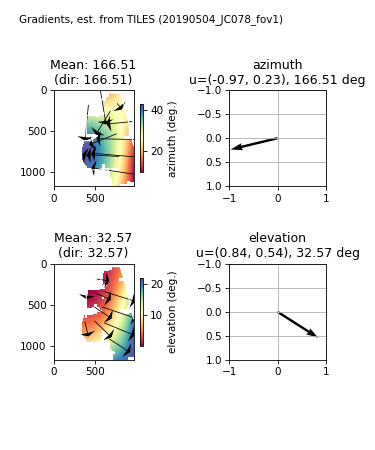

/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_811378_traces001_0f3a16_traces001_931da0_traces001_90b9b0_traces001_b37464_traces001_b062db/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_811378_traces001_0f3a16_traces001_931da0_traces001_90b9b0_traces001_b37464_traces001_b062db/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil


In [60]:
%matplotlib notebook
# Check gradient
spacing =200
scale = 0.0001 #0.0001
width = 0.01 #1 #0.01
headwidth=20

# fig = sct.plot_gradients(az_map_TILE, el_map_TILE, grad_az_TILE, grad_el_TILE,
#                   spacing=spacing, scale=scale, width=width, headwidth=headwidth)
fig = sct.plot_gradients(dk, va, retinorun)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.8, top=0.8)
fig.text(0.05, 0.95, 'Gradients, est. from TILES (%s)' % dk)

pl.savefig(os.path.join(curr_grd_dir, 'np_gradients.svg'))
print(curr_grd_dir)
pl.savefig(os.path.join(test_dir, 'np_gradients.svg'))
print(curr_grd_dir)

In [61]:
def plot_regression_az_and_el(df_, 
                             az_x='ml_pos', az_y='x0', el_x='ap_pos', el_y='y0',
                             xlabel='meas. CTX pos (um)', 
                             ylabel='meas. RET pos (deg)'):
    '''Plot regression for azimuth (left) and elevation (right) for Y on X'''
    fig, axn = pl.subplots(1,2, figsize=(6.5,3))
    ax=axn[0]; ax.set_title('Azimuth');
    sns.regplot(az_x, az_y, df_, ax=ax, scatter_kws=scatter_kws)

    ax=axn[1]; ax.set_title('Elevation');
    sns.regplot(el_x, el_y, df_, ax=ax, scatter_kws=scatter_kws)
    for ax in axn:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    pl.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.8, wspace=0.5)
    return fig

#### Regress MEASURED ctx on ret pos - tiles

In [62]:
scatter_kws={'s':2}

In [63]:
mag_thr=0.
aligned_np, REGR_NP, regr_np_meas = sct.get_aligned_neuropil(dk, va, retinorun,
                                                    GVECTORS)

<IPython.core.display.Javascript object>


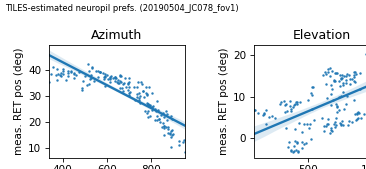

/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_811378_traces001_0f3a16_traces001_931da0_traces001_90b9b0_traces001_b37464_traces001_b062db/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil/check_gradient_alignment measured_ctx_vs_ret


In [64]:
#### Regress MEASURED ctx on ret pos
fig = plot_regression_az_and_el(aligned_np, az_x='ml_pos', az_y='x0', 
                             el_x='ap_pos', el_y='y0',
                             xlabel='meas. CTX pos (um)', 
                             ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.95, 'TILES-estimated neuropil prefs. (%s)' % dk, fontsize=8)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.3)

figname = 'measured_ctx_vs_ret'
pl.savefig(os.path.join(test_dir, '%s.svg' % figname))
print(test_dir, figname)

#### Align CTX to GRADIENT (RFS)

<IPython.core.display.Javascript object>


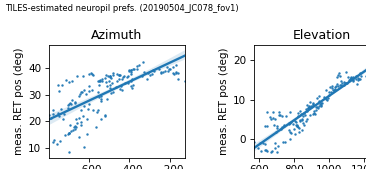

MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.729258 | 4.3124  | 2.14269e-48 |   -0.853966 |    -0.0441307 |   60.7276   | az     |
|  1 | 0.269341 | 5.04863 | 7.87888e-13 |    0.518981 |     0.0133132 |   -0.113461 | el     |
ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.526838 | 5.70094 | 1.91204e-28 |    0.725836 |     0.0359597 |     49.265  | az     |
|  1 | 0.867847 | 2.14711 | 5.65705e-74 |    0.931583 |     0.0307239 |    -19.7492 | el     |
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_811378_traces001_0f3a16_traces001_931da0_traces001_90b9b0_traces001_b37464_traces001_b062db/receptive_fields/fit-2dgaus_dff-no-cuto

In [65]:
#Use NEUROPIL to estimate linear model
mag_thr=0.001
delay_map_thr=1.0
ds_factor=2
# 1. Load neuropil background prefs
retinodf_np = sct.load_neuropil_data(dk, retinorun, mag_thr=mag_thr, 
                                delay_map_thr=delay_map_thr, ds_factor=ds_factor)
curr_np = retinodf_np[retinodf_np.visual_area=='Lm']
# 2. Align FOV to gradient vector direction 
aligned_, M = sct.project_onto_gradient(curr_np, GVECTORS,
                                  xlabel='ml_pos', ylabel='ap_pos')
aligned_np = pd.concat([curr_np, aligned_], axis=1).dropna()
REGR_NP = sct.regress_cortex_and_retino_pos(aligned_np, xvar='proj', model='ridge')

# 3. Use NEUROPIL to estimate linear model
# REGR_NP = sct.regress_cortex_and_retino_pos(aligned_np, xvar='proj', model='ridge')
regr_np_meas = sct.regress_cortex_and_retino_pos(aligned_np, xvar='pos', model='ridge')
# Save
fig = plot_regression_az_and_el(aligned_np, az_x='ml_proj', az_y='x0', 
                             el_x='ap_proj', el_y='y0',
                             xlabel='aligned CTX pos (um)', 
                             ylabel='meas. RET pos (deg)')
print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

fig.text(0.01, 0.95, 'TILES-estimated neuropil prefs. (%s)' % dk, fontsize=8)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.3)


figname = 'projected_ctx_vs_measured_ret'
pl.savefig(os.path.join(curr_grd_dir, '%s.svg' % figname))
print(test_dir, figname)

<IPython.core.display.Javascript object>


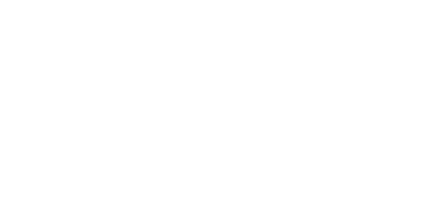

In [38]:
fig, axn = pl.subplots(1,2, figsize=(6.5, 3))
ax=axn[0]
sns.regplot('ml_pos', 'ml_proj', data=aligned_np, ax=ax, scatter_kws=scatter_kws)
ax=axn[1]
sns.regplot('ap_pos', 'ap_proj', data=aligned_np, ax=ax, scatter_kws=scatter_kws)
# for ax in axn:
#     ax.set_aspect('equal')
#     ax.set_ylim([0, 1250])
#     ax.set_xlim([0, 1250])
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8)

Lm 20190512_JC083_fov1
Do model? False
... loading gradient vectors (20190512_JC083_fov1, Lm)
    found: 20190512_JC083_fov1, Lm dict_keys(['Lm', 'V1'])
    found: 20190512_JC083_fov1, Lm dict_keys(['Lm', 'V1'])


<IPython.core.display.Javascript object>


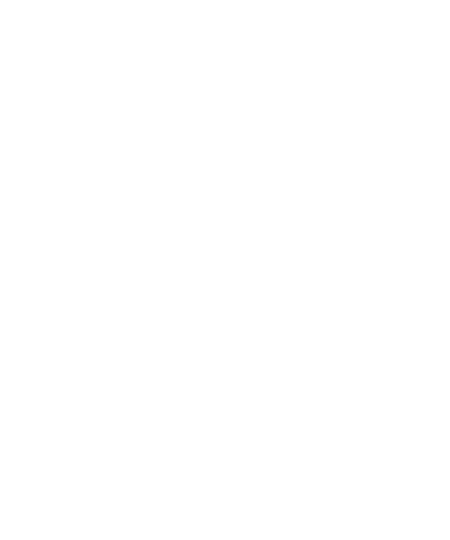

<IPython.core.display.Javascript object>


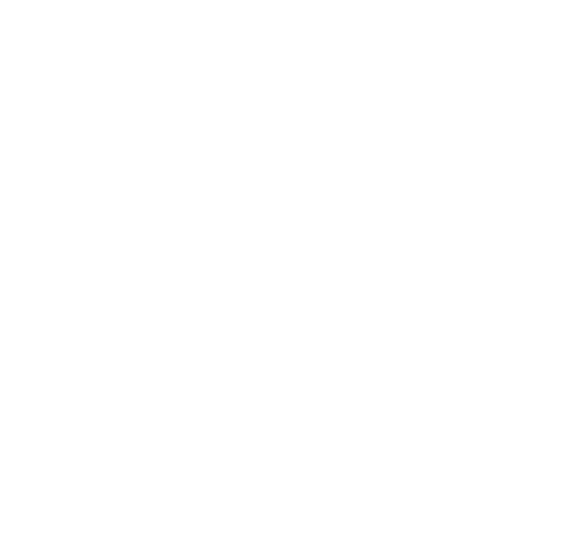

<IPython.core.display.Javascript object>


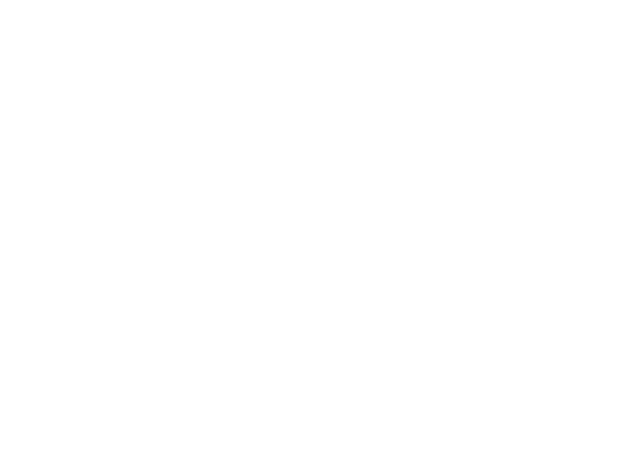

... calculating deviations


<IPython.core.display.Javascript object>


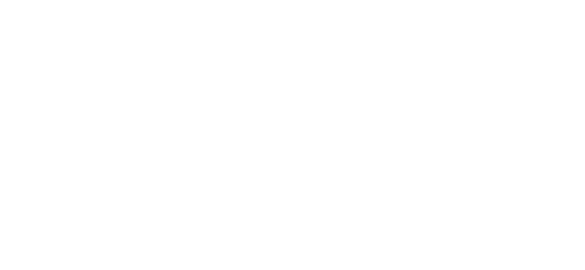

In [107]:
print(va, dk)
devs = sct.do_scatter_analysis(dk, va, do_gradients=False, do_model=False)


In [108]:
devs

,cell,deg_scatter,dist_scatter,inbounds,axis
0,4,0.664861,13.377322,True,az
1,6,3.390083,68.210142,True,az
2,11,0.120471,2.423943,True,az
3,21,1.738028,34.969975,True,az
4,25,1.782208,35.858913,True,az
...,...,...,...,...,...
95,342,7.563890,487.721534,True,el
96,343,6.068307,391.285930,True,el
97,346,0.541915,34.942836,True,el
98,350,7.987531,515.038013,True,el


In [565]:
import scipy.stats as spstats

Measured ctx to y0: r=0.881 (p=0.000)
Aligned ctx to y0: r=0.881 (p=0.000)
0.880835679342935 0.8808357024004139


<IPython.core.display.Javascript object>


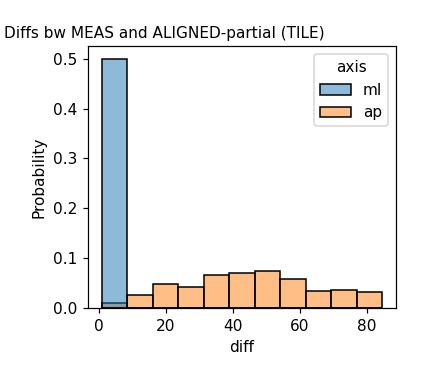

Text(0.01, 0.9, 'Diffs bw MEAS and ALIGNED-partial (TILE)')

In [566]:
r0, p0 = spstats.pearsonr(aligned_TILE['y0'].values, aligned_TILE['ap_pos'].values)
r1, p1 = spstats.pearsonr(aligned_TILE['y0'].values, aligned_TILE['ap_proj'].values)
print('Measured ctx to y0: r=%.3f (p=%.3f)' % (r0, p0))
print('Aligned ctx to y0: r=%.3f (p=%.3f)' % (r1, p1))
print(r1, r0)

diffs_ml = aligned_TILE['ml_pos'].round(2)-aligned_TILE['ml_proj'].round(2)
diffs_ap = aligned_TILE['ap_pos'].round(2)-aligned_TILE['ap_proj'].round(2)
diffs_true_proj = pd.DataFrame({'ml': diffs_ml.abs(), 'ap': diffs_ap.abs()})
diffs_ = diffs_true_proj.stack().reset_index()\
            .rename(columns={'level_1': 'axis', 0: 'diff'})

fig, ax = pl.subplots(figsize=(4,3.5))
sns.histplot(diffs_, x='diff', hue='axis', ax=ax, stat='probability', 
             common_norm=True, common_bins=True)
pl.subplots_adjust(left=0.2, bottom=0.2)
fig.text(0.01, 0.9, 'Diffs bw MEAS and ALIGNED-partial (TILE)')

## Load GRADIENTS (MBAR)

In [806]:
def load_movingbar_results(dk, retinorun):
    # load retinodata
    retinoid, RETID = retutils.load_retino_analysis_info(
                        dk, run=retinorun, use_pixels=False)
    data_id = '_'.join([dk, retinorun, retinoid])
    print("DATA ID: %s" % data_id)
    scaninfo = retutils.get_protocol_info(dk, run=retinorun)

    # Image dimensions
    d2_orig = scaninfo['pixels_per_line']
    d1_orig = scaninfo['lines_per_frame']
    print("Original dims: [%i, %i]" % (d1_orig, d2_orig))
    ds_factor = int(RETID['PARAMS']['downsample_factor'])
    print('Data were downsampled by %i.' % ds_factor)
    # Get pixel size
    pixel_size = hutils.get_pixel_size()
    pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
    d1 = int(d1_orig/ds_factor)
    d2 = int(d2_orig/ds_factor)
    print(d1, d2)
    # Load fft 
    fft_results = retutils.load_fft_results(dk,
                                    retinorun=retinorun, traceid=traceid, 
                                    rootdir=rootdir, create_new=False,
                                    use_pixels=False)
    fft_soma = fft_results['fft_soma']
    fft_np = fft_results['fft_neuropil']
    # Create dataframe of magratios -- each column is a condition
    magratios_soma, phases_soma = retutils.extract_from_fft_results(fft_soma)
    magratios_np, phases_np = retutils.extract_from_fft_results(fft_np)
    dims = (d1_orig, d2_orig)
    
    return magratios_soma, phases_soma, magratios_np, phases_np, dims

In [568]:
def get_best_retinorun(datakey):
    all_retinos = retutils.get_average_mag_across_pixels(datakey)     
    retinorun = all_retinos.loc[all_retinos[1].idxmax()][0] 
    return retinorun

# def load_gradient_results(datakey, retinorun, results='vectors', protocol='BAR'):
#     session, animalid, fovnum = hutils.split_datakey_str(datakey)
#     fpaths = [f for f in glob.glob(os.path.join(rootdir, animalid, 
#                 session, 'FOV%i_*' % fovnum, '%s*' % retinorun, 
#                 'retino_analysis/retino_structure', 
#                 '%s_*.pkl' % results)) if '_pixels_thr' not in f] 
#     for fp in fpaths:
#         print(fp)
#     fpath = fpaths[-1]
#     with open(fpath, 'rb') as f:
#         gvectors = pkl.load(f, encoding='latin1')
    
#     if results=='projections':
#         gvectors = gvectors['regr_df']
        
#     return gvectors

def load_neuropil_background(datakey, retinorun, map_type='final', protocol='BAR'):
    '''
    Load NP background (MOVINGBAR). Saved by notebook
    ./retinotopy/identify_visual_areas.ipynb.
    TODO:  Clean up, so all this stuff in same place 
    (retino_structure - has projections_, vectors_.pkl
    vs. segmentation - has smoothed/processed maps)
    '''
    session, animalid, fovnum = hutils.split_datakey_str(datakey)
    maps_fpaths = glob.glob(os.path.join(rootdir, animalid, 
                        session, 'FOV%i_*' % fovnum, '%s*' % retinorun, 
                        'retino_analysis/segmentation/smoothed_maps.npz'))[0]
    maps = np.load(maps_fpaths)
    if map_type=='final':
        az_ = maps['azimuth']
        el_ = maps['elevation']
    else:
        az_ = maps['start_az']
        el_ = maps['start_el']
    # screen info
    screen = hutils.get_screen_dims()
    screen_max = screen['azimuth_deg']/2.
    screen_min = -screen_max
    #### Convert to screen units
    vmin, vmax = (-np.pi, np.pi)
    az_map = hutils.convert_range(az_, oldmin=vmin, oldmax=vmax, 
                                  newmin=screen_min, newmax=screen_max)
    el_map = hutils.convert_range(el_, oldmin=vmin, oldmax=vmax, 
                                  newmin=screen_min, newmax=screen_max)
    #vmin, vmax = (screen_min, screen_max)   
    return az_map, el_map


In [569]:
def adjust_retinodf(mvb_np, mag_thr=0.02):
    # Filter #magthr_2p=0.02
    pass_mag_rois = mvb_np[(mvb_np.mag_az>mag_thr) 
                          & (mvb_np.mag_el>mag_thr)].index.tolist()
    retinodf_np = mvb_np.loc[pass_mag_rois]
    # Get screen info
    screen = hutils.get_screen_dims()
    screen2p_x = screen['azimuth_deg'] # 119.5564
    screen2p_y = screen['altitude_deg'] #67.323
    resolution2p = screen['resolution'] #[1920, 1080] #[1024, 768]
    # Convert to screen coords
    abs_vmin, abs_vmax = (-np.pi, np.pi)
    lmax_az_2p = screen2p_x #/2.
    lmin_az_2p = 0 #-screen2p_x #-lmax_az_2p
    lmax_el_2p = screen2p_y #/2.
    lmin_el_2p = 0 #-screen2p_y# 0 #-lmax_el_2p
    retinodf_np['az_lin'] = hutils.convert_range(retinodf_np['phase_az'], 
                                       newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                       oldmin=abs_vmin, oldmax=abs_vmax)
    retinodf_np['el_lin'] = hutils.convert_range(retinodf_np['phase_el'], 
                                       newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                       oldmin=abs_vmin, oldmax=abs_vmax)
    retinodf_np['x0'] = retinodf_np['az_lin'] - (lmax_az_2p/2.)
    retinodf_np['y0'] = retinodf_np['el_lin'] - (lmax_az_2p/2.)
    
    return retinodf_np

In [572]:
# screen = hutils.get_screen_dims()
# screen_max = screen['azimuth_deg']/2.
# screen_min = -screen_max    
# vmin, vmax = (screen_min, screen_max)   
# print(vmin, vmax)

In [809]:
retinorun = get_best_retinorun(dk)
print(dk, retinorun)
az_map_BAR, el_map_BAR = load_neuropil_background(dk, retinorun)
gvectors_BAR0 = load_gradient_results(dk, retinorun, results='vectors', protocol='BAR')
regr_BAR0 = load_gradient_results(dk, retinorun, results='projections', protocol='BAR')

20190513_JC078_fov1 retino_run1
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/retino_run1/retino_analysis/retino_structure/vectors_Lm.pkl
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/retino_run1/retino_analysis/retino_structure/projections_Lm.pkl


<IPython.core.display.Javascript object>


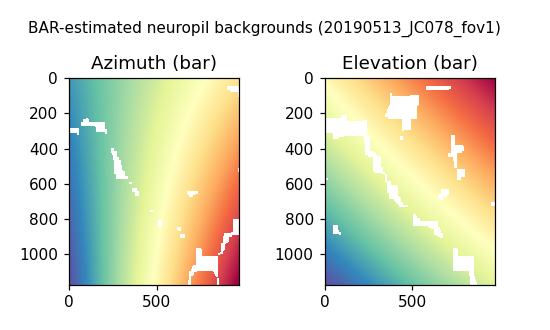

In [810]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(5,3))
axn[0].imshow(az_map_BAR, cmap='Spectral'); axn[0].set_title('Azimuth (bar)');
axn[1].imshow(el_map_BAR, cmap='Spectral'); axn[1].set_title('Elevation (bar)');
fig.text(0.05, 0.9, 'BAR-estimated neuropil backgrounds (%s)' % dk)
pl.subplots_adjust(top=0.8, bottom=0.1, wspace=0.5)

In [811]:
# Compare input map
az_input_BAR, el_input_BAR = load_neuropil_background(dk, retinorun, map_type='input', 
                                        protocol='BAR')

<IPython.core.display.Javascript object>


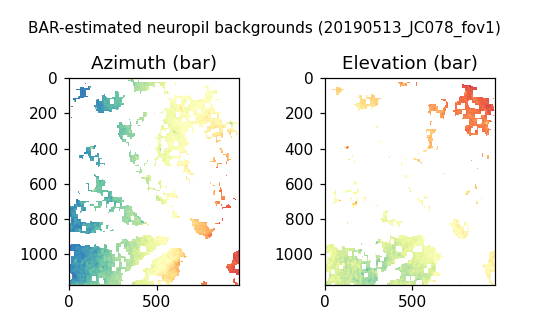

In [812]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(5,3))
axn[0].imshow(az_input_BAR, cmap='Spectral'); axn[0].set_title('Azimuth (bar)');
axn[1].imshow(el_input_BAR, cmap='Spectral'); axn[1].set_title('Elevation (bar)');
fig.text(0.05, 0.9, 'BAR-estimated neuropil backgrounds (%s)' % dk)
pl.subplots_adjust(top=0.8, bottom=0.1, wspace=0.5)

In [813]:
grad_az_BAR = seg.image_gradient(az_map_BAR)
grad_el_BAR = seg.image_gradient(el_map_BAR)
gvectors_BAR = {'az': grad_az_BAR['vhat'], 'el': grad_el_BAR['vhat']}

In [814]:
test_dir

'/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil/check_gradient_alignment'

<IPython.core.display.Javascript object>


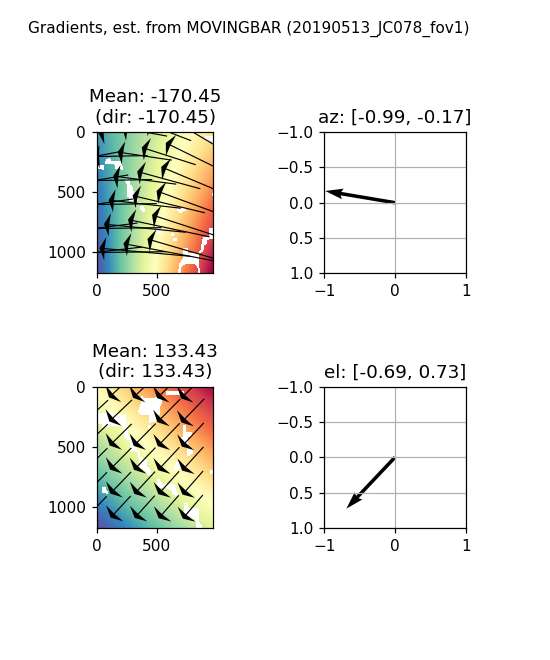

/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil


In [815]:
fig = grd.plot_gradients(az_map_BAR, el_map_BAR, grad_az_BAR, grad_el_BAR,
                  spacing=spacing, scale=scale, width=width, headwidth=headwidth)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.8, top=0.8)
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk)

pl.savefig(os.path.join(test_dir, 'np_gradients_BAR.svg'))
print(curr_grd_dir)

In [816]:
mag_thr=0.001
delay_map_thr=1.0
ds_factor=2
mags_soma, phases_soma, mags_np, phases_np, dims = load_movingbar_results(dk, 
                                                                          retinorun)
# #### Get maps:  abs_vmin, abs_vmax = (-np.pi, np.pi)
mvb_np = retutils.get_final_maps(mags_np, phases_np, 
                    trials_by_cond=None,
                    mag_thr=mag_thr, dims=dims,
                    ds_factor=ds_factor, use_pixels=False)
# add pos
mvb_np['cell'] = mvb_np.index.tolist()
mvb_np = hutils.add_meta_to_df(mvb_np, {'datakey': dk, 'visual_area': va,
                                        'experiment': experiment})
mvb_np = aggr.add_roi_positions(mvb_np)
# adjust to LIN coords
retinodf_np = adjust_retinodf(mvb_np.dropna(), magthr_2p=0.02)

DATA ID: 20190513_JC078_fov1_retino_run1_analysis002
Original dims: [512, 512]
Data were downsampled by 2.
256 256
Adding ROI position info...


<IPython.core.display.Javascript object>


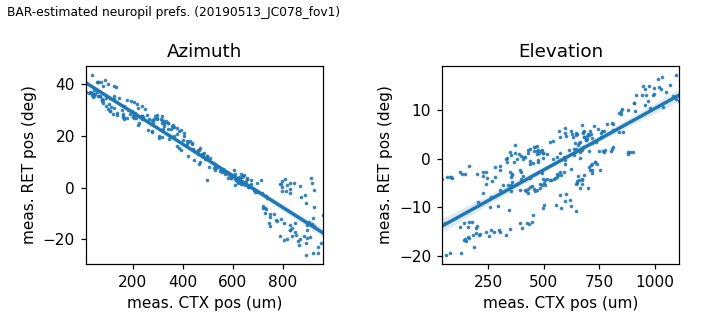

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil/check_gradient_alignment measured_ctx_vs_ret_BAR


In [817]:
#### Regress MEASURED ctx on ret pos
fig = plot_regression_az_and_el(retinodf_np, az_x='ml_pos', az_y='x0', 
                             el_x='ap_pos', el_y='y0',
                             xlabel='meas. CTX pos (um)', 
                             ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.95, 'BAR-estimated neuropil prefs. (%s)' % dk, fontsize=8)
figname = 'measured_ctx_vs_ret_BAR'
pl.savefig(os.path.join(test_dir, '%s.svg' % figname))
print(test_dir, figname)

#### ALIGN ctx to gradient -- BAR

<IPython.core.display.Javascript object>


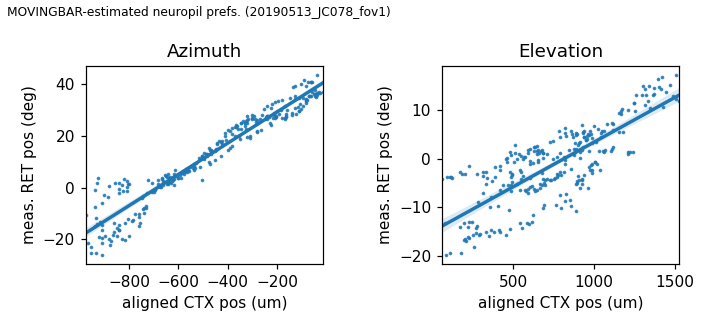

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil/check_gradient_alignment projected_ctx_vs_measured_ret_BAR


In [818]:
# Use NEUROPIL to estimate linear model
BAR_proj, BAR_az, BAR_el = grd.X_align_cortex_to_gradient(retinodf_np, 
                                                        gvectors_BAR,
                                  xlabel='ml_pos', ylabel='ap_pos')
aligned_BAR = pd.concat([retinodf_np, BAR_proj], axis=1).dropna()
# PLOT
fig = plot_regression_az_and_el(aligned_BAR, 
                             az_x='ml_proj', az_y='x0', 
                             el_x='ap_proj', el_y='y0',
                             xlabel='aligned CTX pos (um)', 
                             ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.95, 'MOVINGBAR-estimated neuropil prefs. (%s)' % dk, fontsize=8)
figname = 'projected_ctx_vs_measured_ret_BAR'
pl.savefig(os.path.join(test_dir, '%s.svg' % figname))
print(test_dir, figname)

Measured ctx to y0: r=0.793 (p=0.000)
Aligned ctx to y0: r=0.793 (p=0.000)
0.7929301277937744 0.7929300563087298


<IPython.core.display.Javascript object>


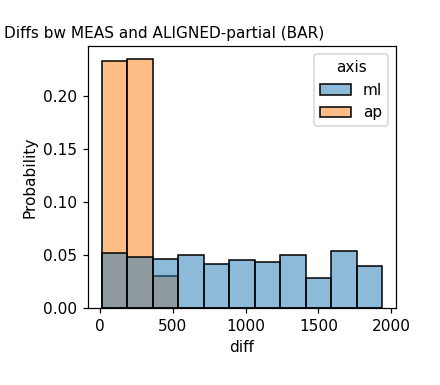

Text(0.01, 0.9, 'Diffs bw MEAS and ALIGNED-partial (BAR)')

In [819]:
r0, p0 = spstats.pearsonr(aligned_BAR['y0'].values, aligned_BAR['ap_pos'].values)
r1, p1 = spstats.pearsonr(aligned_BAR['y0'].values, aligned_BAR['ap_proj'].values)
print('Measured ctx to y0: r=%.3f (p=%.3f)' % (r0, p0))
print('Aligned ctx to y0: r=%.3f (p=%.3f)' % (r1, p1))
print(r1, r0)

diffs_ml = aligned_BAR['ml_pos'].round(2)-aligned_BAR['ml_proj'].round(2)
diffs_ap = aligned_BAR['ap_pos'].round(2)-aligned_BAR['ap_proj'].round(2)
diffs_true_proj = pd.DataFrame({'ml': diffs_ml.abs(), 'ap': diffs_ap.abs()})
diffs_ = diffs_true_proj.stack().reset_index()\
            .rename(columns={'level_1': 'axis', 0: 'diff'})

fig, ax = pl.subplots(figsize=(4,3.5))
sns.histplot(diffs_, x='diff', hue='axis', ax=ax, stat='probability', 
             common_norm=True, common_bins=True)
pl.subplots_adjust(left=0.2, bottom=0.2)
fig.text(0.01, 0.9, 'Diffs bw MEAS and ALIGNED-partial (BAR)')

#### ---- test transformation for alignment ---- 


In [846]:
def full_transmat(df_, u1, u2, axis=0):
    T1_full = grd.change_of_basis(u1, u2)
    transf_az_full = [np.linalg.inv(T1_full) @ np.array([x, y]) \
                  for (x,y) in df_[['ml_pos', 'ap_pos']].values]
    aligned_x_full = np.array([p[axis] for p in transf_az_full])
    return aligned_x_full

def part_transmat(df_, u1, u2, axis=0):
    o1=np.array([1, 0])
    o2=np.array([0, 1])
    if axis==0:
        T1_part = grd.get_transformation_matrix(u1, o2)
    else:
        T1_part = grd.get_transformation_matrix(o1, u2)
    transf_az_part = [T1_part @ np.array([x, y]) for (x,y) in df_[['ml_pos', 'ap_pos']].values]
    aligned_x_part = np.array([p[axis] for p in transf_az_part])
    return aligned_x_part

def scalar_proj(df_, u1, u2, axis=0):
    if axis==0:
        aligned_ = np.array([np.dot(np.array((ml, ap)), u1) \
                        for ml, ap in df_[['ml_pos', 'ap_pos']].values])
    else:
        aligned_ = np.array([np.dot(np.array((ml, ap)), u2) \
                        for ml, ap in df_[['ml_pos', 'ap_pos']].values])
    return aligned_

def transmat(df_, u1, u2, axis=0):
    M = np.array([[u1[0], u1[1]],
                  [u2[0], u2[1]]])
    transf_vs = [M.dot(np.array([x, y])) for (x, y) \
                     in df_[['ml_pos', 'ap_pos']].values]
    t_df = pd.DataFrame(transf_vs, columns=['new_x', 'new_y'], index=df_.index)

    return t_df

In [820]:
import copy

In [840]:
USE_BAR=True
gvectors_=gvectors_BAR.copy() if USE_BAR else gvectors_TILE.copy()
#df_ = retinodf_np.copy() if USE_BAR else fitdf_np.copy()
aligned_df = aligned_BAR.copy() if USE_BAR else aligned_TILE.copy()

xlabel='ml_pos'
ylabel='ap_pos'

u1 = (gvectors_['az'])
u2 = (gvectors_['el'])
o1 = np.array([1, 0]) + np.finfo(np.float32).eps
o2 = np.array([0, 1]) + np.finfo(np.float32).eps

In [841]:
u1, u2

(array([-0.98613291, -0.16595745]), array([-0.68742005,  0.72626006]))

In [860]:
importlib.reload(grd)

<module 'analyze2p.gradients' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gradients.py'>

In [861]:
#T1_full = roiutils.get_transformation_matrix(u1, u2)
#transf_az_full = [T1_full @ np.array([x, y]) for (x,y) in df_[['ml_pos', 'ap_pos']].values]
# T1_full = grd.change_of_basis(u1, u2)
# transf_az_full = [np.linalg.inv(T1_full) @ np.array([x, y]) \
#                   for (x,y) in df_[['ml_pos', 'ap_pos']].values]
# aligned_x_full = np.array([p[0] for p in transf_az_full])

# T1_part = roiutils.get_transformation_matrix(o1, u2)
# transf_az_part = [T1_part @ np.array([x, y]) for (x,y) in df_[['ml_pos', 'ap_pos']].values]
# aligned_x_part = np.array([p[0] for p in transf_az_part])
# aligned_df['ml_proj_part'] = aligned_x_part

aligned_df['ml_proj_full'] = full_transmat(aligned_df, u1, u2, axis=0)
aligned_df['ml_proj_part'] = part_transmat(aligned_df, u1, u2, axis=0)
aligned_df['ml_proj_scalar'] = scalar_proj(aligned_df, u1, u2, axis=0)

In [862]:
#T2_full = roiutils.get_transformation_matrix(u1, u2)
#transf_el_full = [T2_full @ np.array([x, y]) for (x,y) in df_[['ml_pos', 'ap_pos']].values]
# T2_full = grd.change_of_basis(u1, u2)
# transf_el_full = [np.linalg.inv(T2_full) @ np.array([x, y]) \
#                   for (x,y) in df_[['ml_pos', 'ap_pos']].values]
# aligned_y_full = np.array([p[1] for p in transf_el_full])
# aligned_df['ap_proj_full'] = aligned_y_full

# T2_part = roiutils.get_transformation_matrix(o1, u2)
# transf_el_part = [T2_part @ np.array([x, y]) for (x,y) in df_[['ml_pos', 'ap_pos']].values]
# aligned_y_part = np.array([p[1] for p in transf_el_part])
# aligned_df['ap_proj_part'] = aligned_y_part
aligned_df['ap_proj_full'] = full_transmat(aligned_df, u1, u2, axis=1)
aligned_df['ap_proj_part'] = part_transmat(aligned_df, u1, u2, axis=1)
aligned_df['ap_proj_scalar'] = scalar_proj(aligned_df, u1, u2, axis=1)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gradients.py:339: RuntimeWarning: divide by zero encountered in double_scalars
  a_21 = 1./ ( (-a*d/b) + c)


In [863]:
tmat = transmat(aligned_df, u1, u2, axis=0)
aligned_df['ml_proj_mat'] = tmat['new_x']
aligned_df['ap_proj_mat'] = tmat['new_y']

<IPython.core.display.Javascript object>


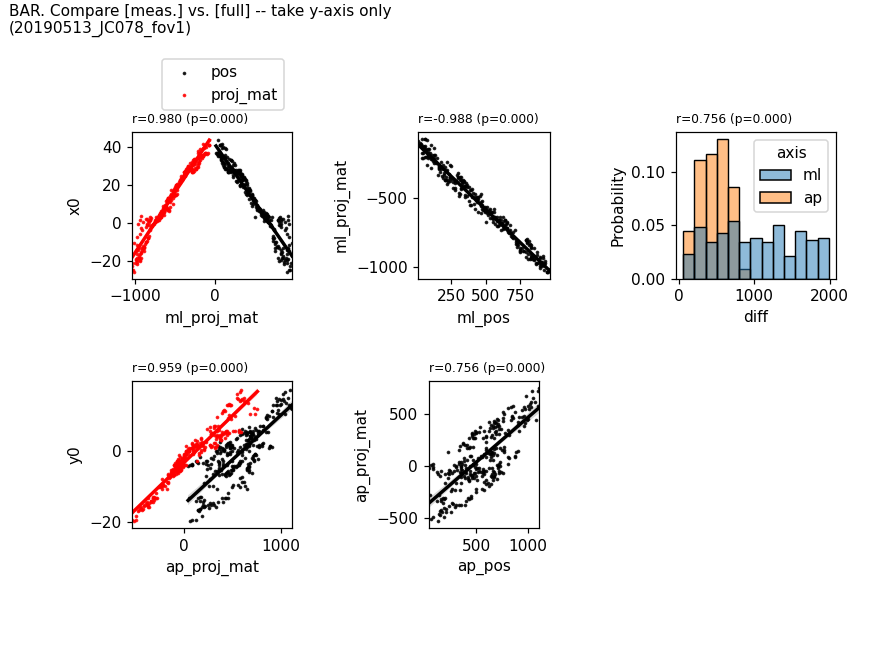

PRE ctx to y0: r=-0.963 (p=0.000)
POST ctx to y0: r=0.980 (p=0.000)


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

PRE ctx to y0: r=0.793 (p=0.000)
POST ctx to y0: r=0.959 (p=0.000)


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Measured ctx to y0: r=0.793 (p=0.000)
Aligned ctx to y0: r=0.959 (p=0.000)
0.9588103891140747 0.7929300563087298


Text(0.01, 0.95, 'BAR. Compare [meas.] vs. [full] -- take y-axis only\n(20190513_JC078_fov1)')

In [877]:
#cond='x'
pre_color='k'
post_color='r'

suffix_pre = 'pos'
suffix_post = 'proj_mat'
# ------------------------------------
protocol='BAR' if USE_BAR else 'TILE'
if suffix_pre=='pos':
    pre_title = 'meas.' 
else:
    if 'scalar' in suffix_pre:
        pre_title = 'scalar'
    else:
        pre_title = 'partial' if suffix_pre=='proj_part' else 'full'
if suffix_post =='pos':
    post_title = 'meas.'
else:
    if 'scalar' in suffix_post:
        post_title='scalar'
    else:
        post_title = 'partial' if suffix_post=='proj_part' else 'full'

fig, axn = pl.subplots(2,3, figsize=(8,6))
for ci, cond in enumerate(['x', 'y']):
    prefix='ml' if cond=='x' else 'ap'
    v2_pre_label = '%s_%s' % (prefix, suffix_pre)
    v2_post_label = '%s_%s' % (prefix, suffix_post)

    v1=aligned_df['%s0' % cond].values
    v2_pre = aligned_df[v2_pre_label].values
    v2_post = aligned_df[v2_post_label].values

    r0, p0 = spstats.pearsonr(v1, v2_pre)
    r1, p1 = spstats.pearsonr(v1, v2_post)
    results_str_pre = 'r=%.3f (p=%.3f)' % (r0, p0)
    results_str_post = 'r=%.3f (p=%.3f)' % (r1, p1)
    print('PRE ctx to y0: %s' % results_str_pre)
    print('POST ctx to y0: %s' % results_str_post)

    # Plot
    ax=axn[ci, 0]; ax.set_title(results_str_pre, loc='left', fontsize=8);
    sns.regplot(v2_pre_label, '%s0' % cond, data=aligned_df, ax=ax, 
                scatter_kws=scatter_kws, color=pre_color, label=suffix_pre)
    ax=axn[ci, 0]; ax.set_title(results_str_post, loc='left', fontsize=8);
    sns.regplot(v2_post_label, '%s0' % cond, data=aligned_df, ax=ax, 
                scatter_kws=scatter_kws, color=post_color, label=suffix_post)
    if ci==0:
        ax.legend(bbox_to_anchor=(1,1.1), loc='lower right')
    # Compare pre/post directly
    r2, p2 = spstats.pearsonr(v2_pre, v2_post)
    results_str_compare = 'r=%.3f (p=%.3f)' % (r2, p2)
    ax=axn[ci, 1]; ax.set_title(results_str_compare, loc='left', fontsize=8);
    sns.regplot(v2_pre_label, v2_post_label, data=aligned_df, ax=ax, 
                scatter_kws=scatter_kws, color='k')
    ax.set_aspect('equal')
    #ax.set_ylim([-400, 1500])
    #ax.set_xlim([-400, 1500])
    
ax=axn[0, 2]; ax.set_title(results_str_compare, loc='left', fontsize=8);
r0, p0 = spstats.pearsonr(aligned_df['%s0' % cond].values, 
                          aligned_df[v2_pre_label].values)
r1, p1 = spstats.pearsonr(aligned_df['%s0' % cond].values, 
                          aligned_df[v2_post_label].values)
print('Measured ctx to y0: r=%.3f (p=%.3f)' % (r0, p0))
print('Aligned ctx to y0: r=%.3f (p=%.3f)' % (r1, p1))
print(r1, r0)
diffs_ml = aligned_df['ml_%s' % suffix_pre].round(2)\
            -aligned_df['ml_%s' % suffix_post].round(2)
diffs_ap = aligned_df['ap_%s' % suffix_pre].round(2)\
            -aligned_df['ap_%s' % suffix_post].round(2)
diffs_true_proj = pd.DataFrame({'ml': diffs_ml.abs(), 'ap': diffs_ap.abs()})
diffs_ = diffs_true_proj.stack().reset_index()\
            .rename(columns={'level_1': 'axis', 0: 'diff'})
sns.histplot(diffs_, x='diff', hue='axis', ax=ax, stat='probability', 
             common_norm=True, common_bins=True)

pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2,top=0.8,
                  hspace=0.7, wspace=0.7)
axn.flat[-1].axis('off')
fig.text(0.01, 0.95, \
         '%s. Compare [%s] vs. [%s] -- take %s-axis only\n(%s)' \
         % (protocol, pre_title, post_title, cond, dk))

#### Fit linear model between (projected) CTX pos and RET pos

In [887]:
USE_BAR=True
projection_type='mat'
# -----------------------------------------------------------------
aligned_df = aligned_BAR.copy() if USE_BAR else aligned_TILE.copy()
gvectors_=gvectors_BAR.copy() if USE_BAR else gvectors_TILE.copy()

u1 = (gvectors_['az'])
u2 = (gvectors_['el'])

if projection_type=='mat':
    tmat = transmat(aligned_df, u1, u2, axis=0)
    aligned_df['ml_proj'] = tmat['new_x']
    aligned_df['ap_proj'] = tmat['new_y']
else:
    for ci, cond in enumerate(['ml', 'ap']):
        if projection_type=='scalar':
            aligned_df['%s_proj' % cond] = scalar_proj(aligned_df, u1, u2, axis=ci)
        elif projection_type=='part':
            aligned_df['%s_proj'% cond] = part_transmat(aligned_df, u1, u2, axis=ci)
        elif projection_type=='full':
            aligned_df['%s_proj'% cond] = full_transmat(aligned_df, u1, u2, axis=ci)

# Do regression
REGR_ = grd.regress_cortex_and_retino_pos(aligned_df, xvar='proj', model='ridge')
REGR_

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond
0,0.960388,3.461630,1.546733e-195,0.979994,0.063983,47.896081,az
1,0.919317,2.236188,6.837141e-153,0.958810,0.026639,-3.148217,el


In [901]:
REGR_

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond
0,0.960388,3.461630,1.546733e-195,0.979994,0.063983,47.896081,az
1,0.919317,2.236188,6.837141e-153,0.958810,0.026639,-3.148217,el


In [884]:
importlib.reload(grd)

<module 'analyze2p.gradients' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gradients.py'>

In [888]:
regr_MEAS = grd.regress_cortex_and_retino_pos(aligned_df, xvar='pos', model='ridge')
regr_MEAS

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond
0,0.927688,4.677064,1.853721e-159,-0.963166,-0.060996,41.139567,az
1,0.628738,4.796875,2.493656e-61,0.792930,0.025249,-14.923396,el


|    |       R2 |    RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.960388 | 3.46163 | 1.54673e-195 |    0.979994 |     0.0639828 |    47.8961  | az     |
|  1 | 0.919317 | 2.23619 | 6.83714e-153 |    0.95881  |     0.0266394 |    -3.14822 | el     |


<IPython.core.display.Javascript object>


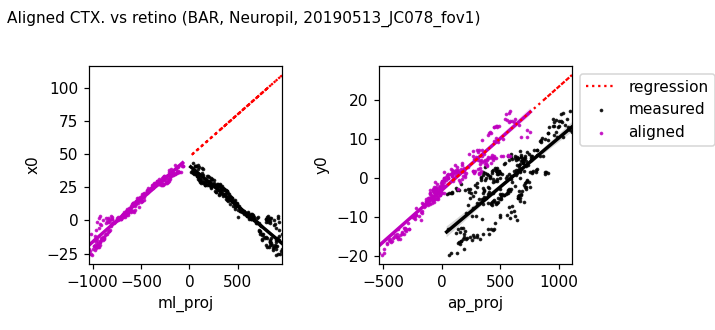

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

Text(0.01, 0.93, 'Aligned CTX. vs retino (BAR, Neuropil, 20190513_JC078_fov1)')

In [889]:
# Q:  why is reversal (LM) wonky
# Q:  fit SOMA to eitehr BAR or TILE gradient
print(REGR_.to_markdown())
fig, axn = pl.subplots(1,2, figsize=(6.5,3))
for ax, cond in zip(axn, ['az', 'el']):
    ctx_ = 'ml' if cond=='az' else 'ap'
    ret_ = 'x' if cond=='az' else 'y'
    sns.regplot('%s_pos' % ctx_, '%s0' % ret_, data=aligned_df, 
                ax=ax, color='k', scatter_kws={'s':2}, label='measured')
    sns.regplot('%s_proj' % ctx_, '%s0' % ret_, data=aligned_df, 
                ax=ax, color='m', scatter_kws={'s':2}, label='aligned')
#     sns.regplot('%s_proj_part' % ctx_, '%s0' % ret_, data=aligned_df, 
#                 ax=ax, color='m', scatter_kws={'s':2}, label='aligned-part')
#     sns.regplot('%s_proj_full' % ctx_, '%s0' % ret_, data=aligned_df, 
#                 ax=ax, color='c', scatter_kws={'s':2}, label='aligned-full')
    # show linear fit
    (slope, intercept), = REGR_[REGR_.cond==cond][['coefficient', 'intercept']].values
    xvs = aligned_df['%s_pos' % ctx_].values
    yvs = xvs*slope + intercept
    ax.plot(xvs, yvs, 'r:', label='regression')
pl.subplots_adjust(bottom=0.2, wspace=0.5, right=0.8, top=0.8)
pl.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.text(0.01, 0.93, 'Aligned CTX. vs retino (BAR, Neuropil, %s)' % dk)

In [890]:
def load_soma_estimates(dk, experiment='rfs', retinorun='retino_run1', 
                        protocol='BAR'):
    if protocol=='BAR':
        magthr_2p=0.001
        delay_map_thr=1.0
        ds_factor=2
        mags_soma, phases_soma, mags_np, phases_np, dims = load_movingbar_results(dk, 
                                                                    retinorun)
        # #### Get maps:  abs_vmin, abs_vmax = (-np.pi, np.pi)
        mvb_soma = retutils.get_final_maps(mags_soma, phases_soma, 
                            trials_by_cond=None,
                            mag_thr=magthr_2p, dims=dims,
                            ds_factor=ds_factor, use_pixels=False)
        # add pos
        mvb_soma['cell'] = mvb_soma.index.tolist()
        mvb_soma = hutils.add_meta_to_df(mvb_soma, {'datakey': dk, 'visual_area': va,
                                                'experiment': experiment})
        mvb_soma = aggr.add_roi_positions(mvb_soma)
        # adjust to LIN coords
        retinodf_soma = adjust_retinodf(mvb_soma.dropna(), magthr_2p=0.01)
        df = retinodf_soma.copy()
    else:
        fit_results, fit_params = rfutils.load_fit_results(dk, experiment=experiment,
                        traceid=traceid, response_type=response_type,
                        is_neuropil=False,
                        do_spherical_correction=do_spherical_correction)
        fitdf_all = rfutils.rfits_to_df(fit_results, fit_params, 
                                convert_coords=True, scale_sigma=True)
        fitdf_soma = fitdf_all[fitdf_all['r2']>fit_thr].copy()
        # Add position info
        fitdf_soma['cell'] = fitdf_soma.index.tolist()
        fitdf_soma = hutils.add_meta_to_df(fitdf_soma, {'datakey': dk, 'visual_area': va,
                                                        'experiment': experiment})
        fitdf_soma = aggr.add_roi_positions(fitdf_soma)
        df = fitdf_soma.copy()
    return df

In [892]:
df_soma = load_soma_estimates(dk, protocol='TILES', 
                              experiment=experiment, retinorun=retinorun)
print(df_soma.shape)
df_soma['cell'] = df_soma.index.tolist()
df_soma = df_soma.reset_index(drop=True)

Adding ROI position info...
(23, 21)


In [893]:
df_soma.tail()

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2,cell,datakey,...,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
18,36.492472,25.237906,56.052512,32.465072,6.119935,-0.014155,0.117023,0.780870,203,20190513_JC078_fov1,...,rfs,JC078,FOV1_zoom2p0x,20190513,336.457143,146,734.835225,386,237.964775,841.142857
19,32.579150,20.169225,39.656328,35.274686,0.592768,-0.010262,0.067349,0.600797,204,20190513_JC078_fov1,...,rfs,JC078,FOV1_zoom2p0x,20190513,329.543640,143,761.487280,400,211.312720,848.056360
20,41.276285,10.319202,21.103633,12.174398,6.280960,-0.016463,0.450356,0.905371,244,20190513_JC078_fov1,...,rfs,JC078,FOV1_zoom2p0x,20190513,679.827789,295,904.266145,475,68.533855,497.772211
21,33.642319,13.240892,54.689666,17.006299,2.839293,-0.006937,0.053455,0.527305,259,20190513_JC078_fov1,...,rfs,JC078,FOV1_zoom2p0x,20190513,583.038748,253,763.390998,401,209.409002,594.561252
22,25.210913,11.660613,21.305452,37.484870,1.849128,-0.004089,0.036352,0.507604,273,20190513_JC078_fov1,...,rfs,JC078,FOV1_zoom2p0x,20190513,368.720157,160,622.515851,327,350.284149,808.879843


In [894]:
regr_soma_meas = grd.regress_cortex_and_retino_pos(df_soma, xvar='pos', model='ridge')
regr_soma_meas

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond
0,0.682907,10.68998,0.000001,-0.826382,-0.059917,45.55734,az
1,0.669436,6.98279,0.000002,0.818191,0.039283,-18.18202,el


<IPython.core.display.Javascript object>


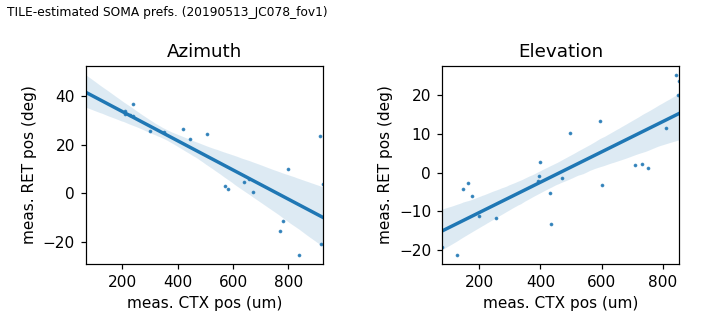

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil/check_gradient_alignment tile_measured_ctx_vs_ret_SOMA


In [895]:
#### Regress MEASURED ctx on ret pos
fig = plot_regression_az_and_el(df_soma, az_x='ml_pos', az_y='x0', 
                             el_x='ap_pos', el_y='y0',
                             xlabel='meas. CTX pos (um)', 
                             ylabel='meas. RET pos (deg)')


fig.text(0.01, 0.95, 'TILE-estimated SOMA prefs. (%s)' % dk, fontsize=8)
figname = 'tile_measured_ctx_vs_ret_SOMA'
pl.savefig(os.path.join(test_dir, '%s.svg' % figname))
print(test_dir, figname)

In [643]:
M = np.array([[u1[0], u1[1]],
              [u2[0], u2[1]]])
transf_vs = [M.dot(np.array([x, y])) for (x, y) \
                 in df_soma[['ml_pos', 'ap_pos']].values]
transf_vs[0:5]

[array([ 940.77218385, 1205.5264998 ]),
 array([ 877.72037961, 1292.28737577]),
 array([ 761.5361428 , 1236.11180993]),
 array([ 787.44552894, 1078.37709244]),
 array([ 766.40013126, 1073.45091944])]

In [651]:
trans_df = pd.DataFrame(transf_vs, columns=['new_x', 'new_y'])
trans_df.head()

,new_x,new_y
0,940.772184,1205.526500
1,877.720380,1292.287376
2,761.536143,1236.111810
3,787.445529,1078.377092
4,766.400131,1073.450919


In [645]:
dotx = [np.dot(u1, np.array([x, y])) for (x, y) in df_soma[['ml_pos', 'ap_pos']].values]
dotx[0:5]

[940.7721838549996,
 877.7203796145371,
 761.5361428037434,
 787.4455289394949,
 766.4001312631873]

In [646]:
doty = [np.dot(u2, np.array([x, y])) for (x, y) in df_soma[['ml_pos', 'ap_pos']].values]
doty[0:5]

[1205.526499804664,
 1292.2873757736088,
 1236.1118099304736,
 1078.3770924379592,
 1073.4509194389245]

In [896]:
tmat = transmat(df_soma, u1, u2)
df_soma['ml_proj_mat'] = tmat['new_x']
df_soma['ap_proj_mat'] = tmat['new_y']

In [897]:
USE_BAR=True
gvectors_=gvectors_BAR.copy() if USE_BAR else gvectors_TILE.copy()
u1 = (gvectors_['az'])
u2 = (gvectors_['el'])

for ai, cond in enumerate(['az', 'el']):
    cond_str='ml' if cond=='az' else 'ap'
    df_soma['%s_proj_full' % cond_str] = full_transmat(df_soma, u1, u2, axis=ai)
    df_soma['%s_proj_part' % cond_str] = part_transmat(df_soma, u1, u2, axis=ai)
    df_soma['%s_proj_scalar' % cond_str] = scalar_proj(df_soma, u1, u2, axis=ai)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gradients.py:339: RuntimeWarning: divide by zero encountered in double_scalars
  a_21 = 1./ ( (-a*d/b) + c)


<IPython.core.display.Javascript object>


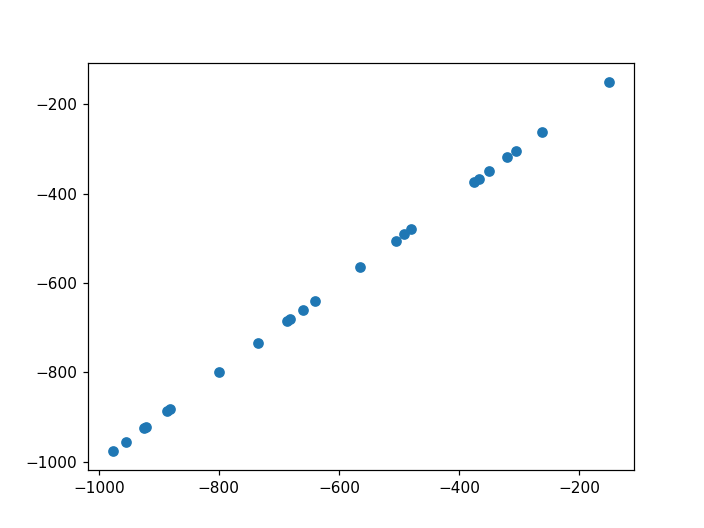

In [898]:
pl.figure()
pl.scatter(df_soma['ml_proj_mat'], df_soma['ml_proj_scalar'])
# pl.scatter(dotx, df_soma['ml_proj_scalar'])


<IPython.core.display.Javascript object>


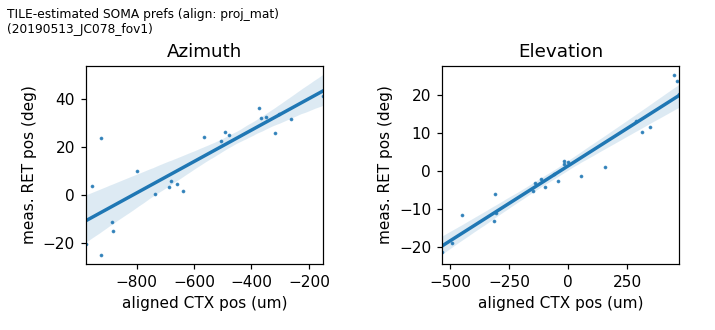

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/receptive_fields/fit-2dgaus_dff-no-cutoff/neuropil/check_gradient_alignment tile_aligned_ctx_vs_ret_SOMA_proj_mat
MEASURED:
|    |       R2 |     RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|---------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.682907 | 10.69    | 1.18181e-06 |   -0.826382 |    -0.0599174 |     45.5573 | az     |
|  1 | 0.669436 |  6.98279 | 1.84538e-06 |    0.818191 |     0.0392833 |    -18.182  | el     |
ALIGNED (proj_mat):
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.733301 | 9.80379 | 1.8604e-07  |    0.85633  |     0.065842  |     53.4128 | az     |
|  1 | 0.9

In [899]:
#### Regress MEASURED ctx on ret pos
projection_type = 'mat'
p_name = 'proj_%s' % projection_type
fig = plot_regression_az_and_el(df_soma, az_x='ml_%s' % p_name, az_y='x0', 
                             el_x='ap_%s' % p_name, el_y='y0',
                             xlabel='aligned CTX pos (um)', 
                             ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.9, 'TILE-estimated SOMA prefs (align: %s)\n(%s)' % (p_name, dk), 
         fontsize=8)
figname = 'tile_aligned_ctx_vs_ret_SOMA_%s' % p_name
pl.savefig(os.path.join(test_dir, '%s.svg' % figname))
print(test_dir, figname)

regr_soma_proj = grd.regress_cortex_and_retino_pos(df_soma, xvar=p_name, model='ridge')
print("MEASURED:")
print(regr_soma_meas.to_markdown())
print("ALIGNED (%s):" % p_name)
print(regr_soma_proj.to_markdown())


In [900]:
p_name

'proj_mat'

In [902]:
regr_soma_proj = grd.regress_cortex_and_retino_pos(df_soma, xvar=p_name, 
                                                   model='ridge')
# REGR_ = regr_soma_proj.copy()
# REGR_
regr_soma_proj

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond
0,0.733301,9.803789,1.860396e-07,0.856330,0.065842,53.412802,az
1,0.936954,3.049520,4.415465e-14,0.967964,0.039423,1.331805,el


In [903]:
zimg, masks, ctrs = roiutils.get_masks_and_centroids(dk, traceid=traceid)
pixel_size = hutils.get_pixel_size()
zimg_r = retutils.transform_2p_fov(zimg, pixel_size)


In [906]:
REGR_ # (should be from np)

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond
0,0.960388,3.461630,1.546733e-195,0.979994,0.063983,47.896081,az
1,0.919317,2.236188,6.837141e-153,0.958810,0.026639,-3.148217,el


In [907]:
p_x = grd.predict_cortex_position(REGR_, cond='az', 
                          points=df_soma['x0'].values)
p_y = grd.predict_cortex_position(REGR_, cond='el', 
                          points=df_soma['y0'].values)
df_soma['predicted_ctx_x'] = p_x
df_soma['predicted_ctx_y'] = p_y

In [908]:
df_soma[['ml_pos', 'ap_pos']].head()

,ml_pos,ap_pos
0,771.005871,730.526810
1,778.620744,709.786301
2,837.636008,599.170254
3,917.592172,433.246184
4,925.207045,255.799609


In [919]:
# CHECK THAT WE GET ORIG coords BACK using inverse
# Get inverse transformation
M = np.array([[u1[0], u1[1]],
              [u2[0], u2[1]]])
transf_vs = [M.dot(np.array([x, y])) for (x, y) \
                 in df_soma[['ml_pos', 'ap_pos']].values]
algn_df = pd.DataFrame(transf_vs, columns=['new_x', 'new_y'], index=df_soma.index)

df_soma['ml_proj_mat'] = algn_df['new_x']
df_soma['ap_proj_mat'] = algn_df['new_y']

# INV_az = np.linalg.inv(M)
# Get inverse transformation
transf_INV = [np.linalg.inv(M).dot(np.array([x, y])) for (x, y) \
               in df_soma[['ml_proj_mat', 'ap_proj_mat']].values]
inv_df = pd.DataFrame(transf_INV, columns=['inv_x', 'inv_y'], index=df_soma.index)

# Re-project transformed coords back to original basis
df_soma['return_proj_x'] = inv_df['inv_x']
df_soma['return_proj_y'] = inv_df['inv_y']

In [921]:
for i in range(20):
    arr_ = np.array(df_soma.iloc[i][['ml_pos', 'ap_pos']].values)
    s0 = np.array(algn_df.iloc[i][['new_x', 'new_y']].values)
    # s1 = np.linalg.inv(M).dot(s0)
    s1 = np.array(inv_df.iloc[i][['inv_x', 'inv_y']].values)
    
    if round(s1[0], 2)!=round(arr_[0], 2):
        print('bad x: %i' % i)
    if round(s1[1], 2)!=round(arr_[1], 2):
        print('bad y: %i' % i)
print('done')

done


<IPython.core.display.Javascript object>


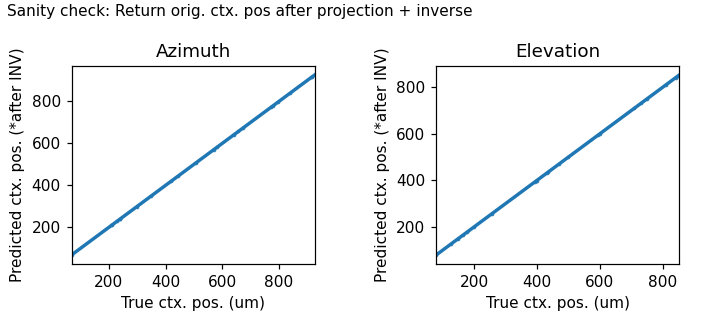

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.01, 0.95, 'Sanity check: Return orig. ctx. pos after projection + inverse')

In [911]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(6.5, 3))
ax=axn[0];ax.set_title('Azimuth');
sns.regplot(df_soma['ml_pos'], df_soma['return_proj_x'], ax=ax,
            scatter_kws=scatter_kws)
ax=axn[1]; ax.set_title('Elevation');
sns.regplot(df_soma['ap_pos'], df_soma['return_proj_y'],ax=ax,
            scatter_kws=scatter_kws)

for ax in axn:
    ax.set_xlabel('True ctx. pos. (um)')
    ax.set_ylabel('Predicted ctx. pos. (*after INV)')
pl.subplots_adjust(bottom=0.2, wspace=0.5, left=0.1, top=0.8, right=0.95)

fig.text(0.01, 0.95, 'Sanity check: Return orig. ctx. pos after projection + inverse')

In [912]:
pred_INV = [np.linalg.inv(M).dot(np.array([x, y])) for (x, y) \
               in df_soma[['predicted_ctx_x', 'predicted_ctx_y']].values]
pred_inv_df = pd.DataFrame(pred_INV, columns=['pred_inv_x', 'pred_inv_y'], 
                      index=df_soma.index)

df_soma['predicted_ctx_x_FOV'] = pred_inv_df['pred_inv_x']
df_soma['predicted_ctx_y_FOV'] = pred_inv_df['pred_inv_y']

In [913]:
import matplotlib as mpl

<IPython.core.display.Javascript object>


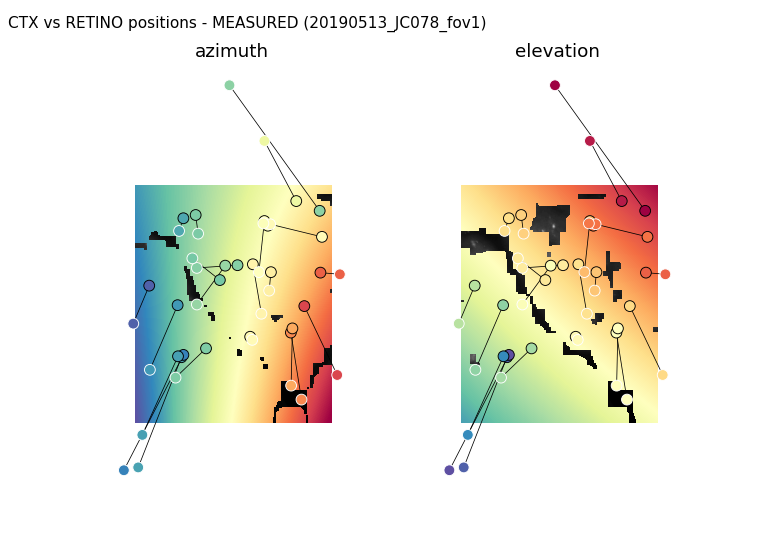

Text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (20190513_JC078_fov1)')

In [916]:
cmap='Spectral'
plot_true=True
plot_predicted=True
plot_lines=True

markersize=50
lw=0.6
alpha=1

df_ = df_soma.copy().reset_index(drop=True)

AZMAP_ = az_map_BAR.copy() if USE_BAR else az_map_TILE.copy()
ELMAP_ = el_map_BAR.copy() if USE_BAR else el_map_TILE.copy()

# Make sure we are in bounds of FOV
max_ypos, max_xpos = AZMAP_.shape
incl_plotdf = df_[(df_['predicted_ctx_x_FOV']>=0) & (df_['predicted_ctx_x_FOV']<=max_xpos)
           & (df_['predicted_ctx_y_FOV']>=0) & (df_['predicted_ctx_y_FOV']<=max_ypos)].copy()
excl_ixs = [i for i in df_.index.tolist() if i not in incl_plotdf.index]
#plotdf = df_.loc[excl_ixs].copy()
#plotdf = incl_plotdf.iloc[0::].copy()
plotdf=df_.copy()


fig, axn = pl.subplots(1, 2, figsize=(7,5))
for ax, cond in zip(axn, ['azimuth', 'elevation']):
    neuropil_map = AZMAP_.copy() if cond=='azimuth' else ELMAP_.copy()
    retino_label='x0' if cond=='azimuth' else 'y0'
    # Set color limits
    vmin = min([np.nanmin(neuropil_map), plotdf[retino_label].min()])
    vmax = max([np.nanmax(neuropil_map), plotdf[retino_label].max()])
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ax.set_title(cond)
    ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
    ax.imshow(neuropil_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    if plot_true:
        # Plot soma
        sns.scatterplot(x='ml_pos', y='ap_pos', data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor='k', zorder=1000) 
    if plot_predicted:
        # Plot soma
        sns.scatterplot(x='predicted_ctx_x_FOV', y='predicted_ctx_y_FOV', 
                data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor='w', zorder=1000) 
    if plot_lines:
        # Plot connecting line
        for (x1, y1), (x2, y2) in zip(\
                plotdf[['predicted_ctx_x_FOV', 'predicted_ctx_y_FOV']].values,
                plotdf[['ml_pos', 'ap_pos']].values):
            ax.plot([x1, x2], [y1, y2], lw=0.5, markersize=0, color='k')
for ax in axn:
    ax.legend_.remove()
    ax.axis('off')
    
fig.text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (%s)' % dk)

In [917]:
df_soma.shape

(23, 35)

<IPython.core.display.Javascript object>


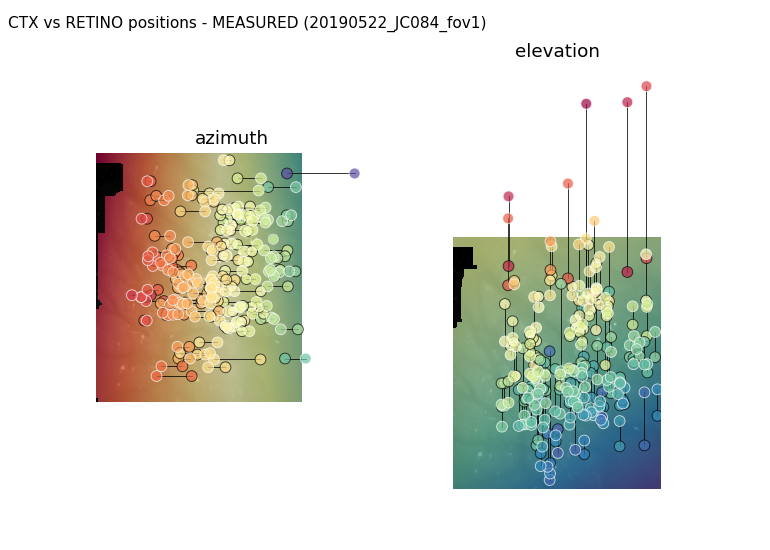

Text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (20190522_JC084_fov1)')

In [787]:
cmap='Spectral'
plot_true=True
plot_predicted=True
plot_lines=True

markersize=50
lw=0.6
alpha=0.7

df_ = df_soma.copy().reset_index(drop=True)

AZMAP_ = az_map_BAR.copy() if USE_BAR else az_map_TILE.copy()
ELMAP_ = el_map_BAR.copy() if USE_BAR else el_map_TILE.copy()

# Make sure we are in bounds of FOV
max_ypos, max_xpos = AZMAP_.shape
incl_plotdf = df_[(df_['predicted_ctx_x_FOV']>=0) & (df_['predicted_ctx_x_FOV']<=max_xpos)
           & (df_['predicted_ctx_y_FOV']>=0) & (df_['predicted_ctx_y_FOV']<=max_ypos)].copy()
excl_ixs = [i for i in df_.index.tolist() if i not in incl_plotdf.index]
#plotdf = df_.loc[excl_ixs].copy()
#plotdf = incl_plotdf.copy()
plotdf=df_.copy()


fig, axn = pl.subplots(1, 2, figsize=(7,5))
for ax, cond in zip(axn, ['azimuth', 'elevation']):
    neuropil_map = AZMAP_.copy() if cond=='azimuth' else ELMAP_.copy()
    retino_label='x0' if cond=='azimuth' else 'y0'
    # Set color limits
    vmin = min([np.nanmin(neuropil_map), plotdf[retino_label].min()])
    vmax = max([np.nanmax(neuropil_map), plotdf[retino_label].max()])
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ax.set_title(cond)
    ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
    ax.imshow(neuropil_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    if plot_true:
        # Plot soma
        sns.scatterplot(x='ml_pos', y='ap_pos', data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor='k', zorder=1000) 
    if plot_predicted:
        # Plot soma
        scatter_x = 'predicted_ctx_x_FOV' if cond=='azimuth' else 'ml_pos'
        scatter_y = 'ap_pos'if cond=='azimuth' else 'predicted_ctx_y_FOV'
        sns.scatterplot(x=scatter_x, y=scatter_y, 
                data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor='w', zorder=1000) 
    if plot_lines:
        # Plot connecting line
        for (x1, y1), (x2, y2) in zip(\
                plotdf[[scatter_x, scatter_y]].values,
                plotdf[['ml_pos', 'ap_pos']].values):
            ax.plot([x1, x2], [y1, y2], lw=0.5, markersize=0, color='k')
for ax in axn:
    ax.legend_.remove()
    ax.axis('off')
    
fig.text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (%s)' % dk)